# A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network

This is an implementation to the paper **"A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network"**. 

The author of the paper said that the proposed algorithm is implemented in Matlab, but we cannot find this implementation, so we implemented it in Python


# Imports


In [5]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold
import os
from tensorflow.keras.models import load_model
import json

import optuna
%matplotlib inline

# matplotlib Settings

In [6]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

# Methods Definitions

In [7]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


# Variables Definitions

In [8]:
path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Prepere Input Files

In [9]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [10]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

# Data Extraction and Preprocessing

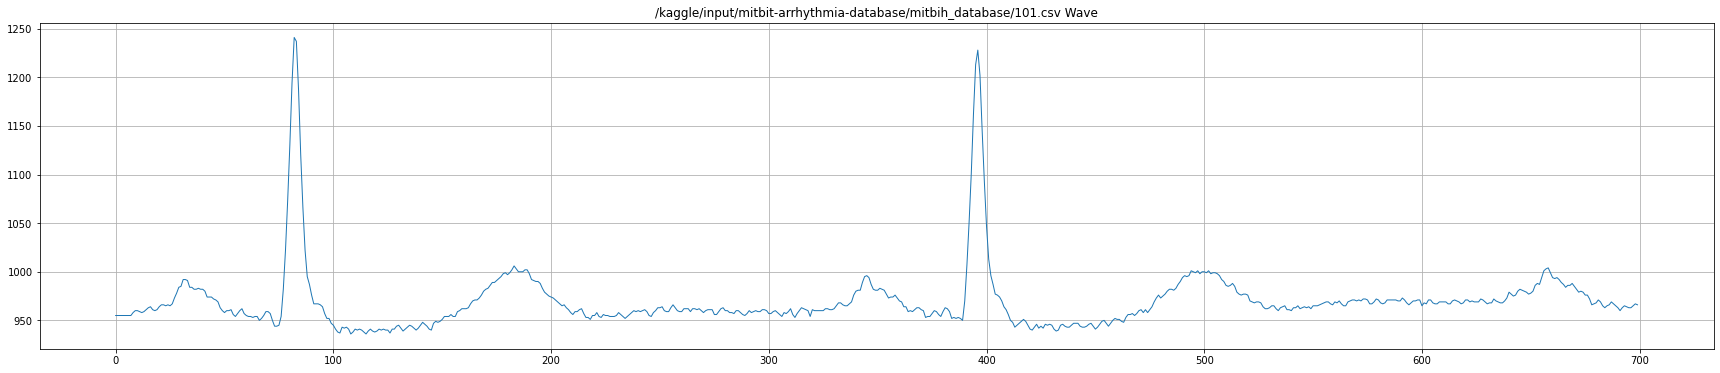

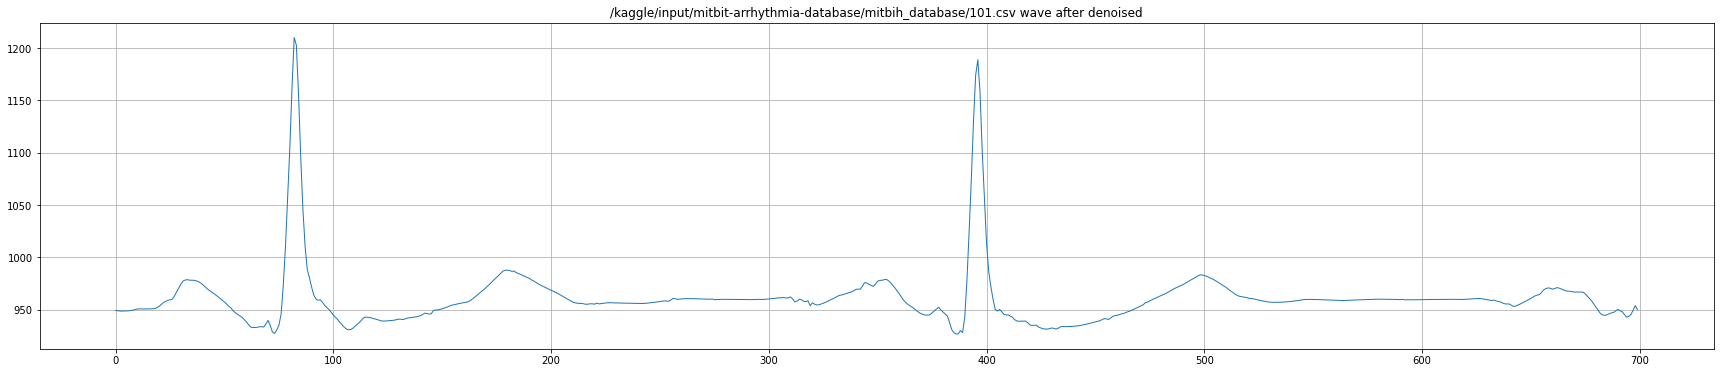

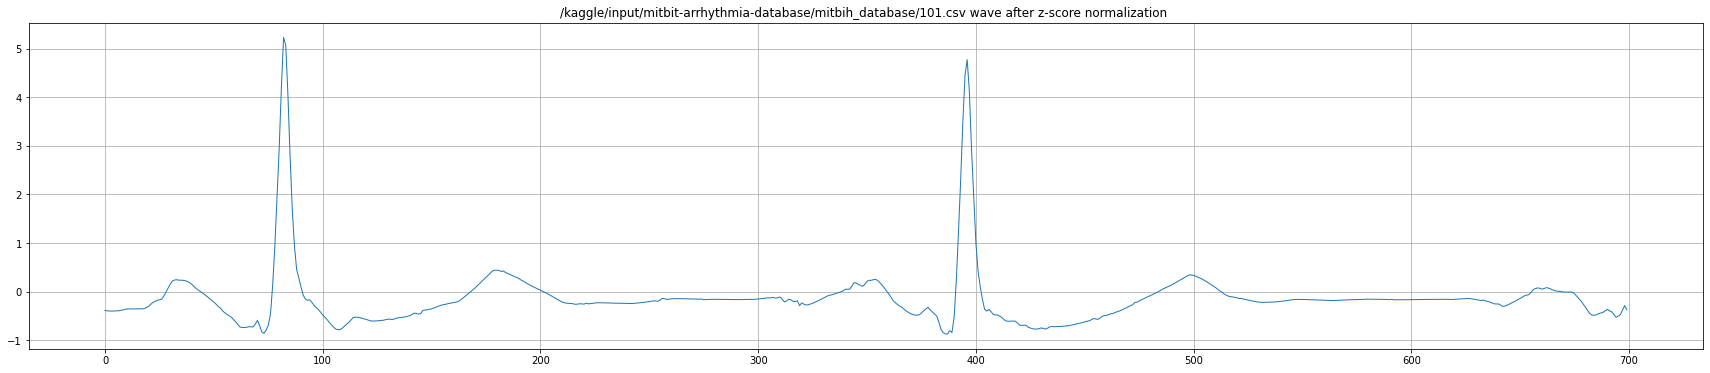

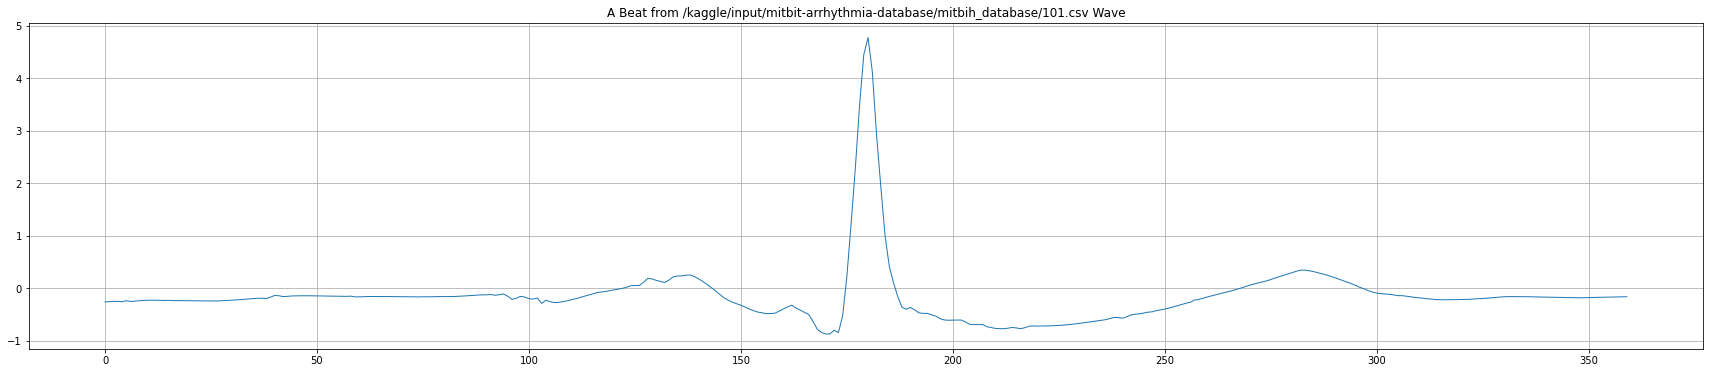

(100012, 360) (100012,)


In [11]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [12]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


# Classes Distribution

0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


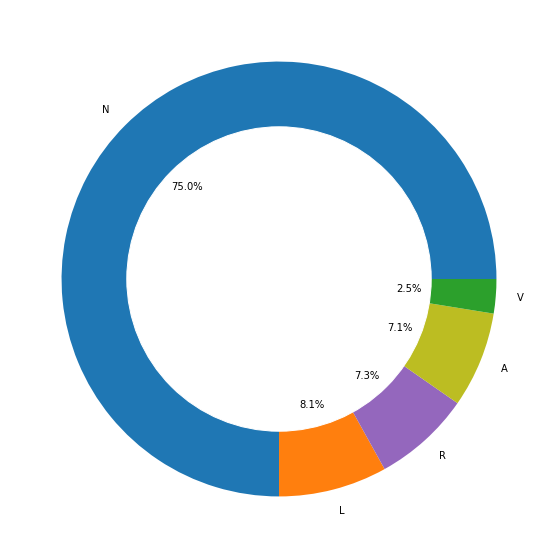

In [13]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Rebalancing Classes

In [14]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=3000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=3000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=3000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=3000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=3000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

4.0    3000
3.0    3000
2.0    3000
1.0    3000
0.0    3000
Name: 360, dtype: int64


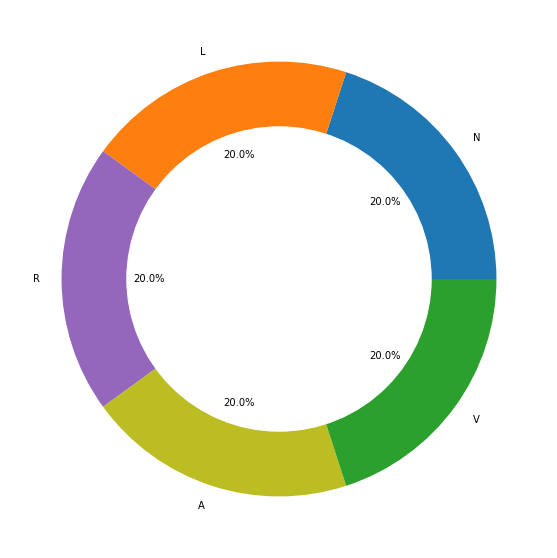

In [15]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Train-Test Split

In [16]:
# Split the original dataset into train and test sets
train, test = train_test_split(X_train_df, test_size=0.20, random_state=42)

# # Further split the training set into train and validation sets
# train, val = train_test_split(train, test_size=0.25, random_state=42)  # 25% of the training set

In [17]:
# Prepare the target and features for training, validation, and test sets
target_train = train[train.shape[1]-1]
# target_val = val[val.shape[1]-1]
target_test = test[test.shape[1]-1]

train_y = to_categorical(target_train)
# val_y = to_categorical(target_val)
test_y = to_categorical(target_test)

In [18]:
train_x = train.iloc[:, :train.shape[1]-1].values
# val_x = val.iloc[:, :val.shape[1]-1].values
test_x = test.iloc[:, :test.shape[1]-1].values

train_x = train_x.reshape(len(train_x), train_x.shape[1], 1)
# val_x = val_x.reshape(len(val_x), val_x.shape[1], 1)
test_x = test_x.reshape(len(test_x), test_x.shape[1], 1)

In [19]:
print("Training set:", train_x.shape, train_y.shape)
# print("Validation set:", val_x.shape, val_y.shape)
print("Test set:", test_x.shape, test_y.shape)

Training set: (12000, 360, 1) (12000, 5)
Test set: (3000, 360, 1) (3000, 5)


## Building the Model Architecture


In [20]:
# Best trial:
#   Value:  0.9679999947547913
#   Params: 
#     num_layers: 3
#     num_filters_0: 64
#     num_filters_1: 64
#     num_filters_2: 96
#     kernel_size_0: 9
#     kernel_size_1: 3
#     kernel_size_2: 7
#     dropout_rate: 0.20368709608876687


In [21]:
# Instanciate an empty model
model = Sequential()

# Adding a Convolution Layer C1
# Input shape = (360 x 1)
# Number of filters = 64
# Filter size = 9
# Padding = 'same' (output size matches input size, 360)
# Strides = 1
# Size of each feature map in C1 is (N/S) = 360/1 = 360
# Number of parameters = (9*1 + 1)*64 = 640
model.add(Conv1D(filters=64, kernel_size=9, padding='same', activation='relu',input_shape=(360, 1)))


# Adding an Average Pooling Layer S1
# Input shape = (360 x 16)
# Filter size (pool size) = 3
# Padding = 0
# Strides = 2
# Size of each feature map in S2 = (N-f+2P)/S + 1 = (360-3+0)/2 + 1 = 179
# Output shape = (179 x 16)
# No trainable parameters (pooling layers do not have weights or biases)
model.add(AvgPool1D(pool_size=3, strides=2))





# Adding a Convolution Layer C2
# Input shape = (179 x 16)
# Number of filters = 64
# Filter size = 3
# Padding = 'same' (output size matches input size)
# Strides = 1
# Size of each feature map in C2 = (N) = 179 (due to 'same' padding)
# Output shape = (179 x 64)
# Number of parameters = (3*16 + 1)*64 = 3136
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))


# Adding an Average Pooling Layer S2
# Input shape = (179 x 32)
# Number of filters = Not applicable for pooling layers
# Filter size = 3
# Padding = 0
# Strides = 2
# Output shape = (89 x 32)
# Number of parameters = 0 (pooling layers do not have parameters)
model.add(AvgPool1D(pool_size=3, strides=2))


# Adding a Convolution Layer C3
# Input shape = (44 x 64)
# Number of filters = 96
# Filter size = 7
# Padding = 'same' (output size matches input size)
# Strides = 1
# Output shape = (44 x 96)
# Number of parameters = (7*64 + 1)*96 = 43008
model.add(Conv1D(filters=96, kernel_size=7, padding='same', activation='relu'))


# Adding an Average Pooling Layer S3
# Input shape = (44 x 128)
# Number of filters = Not applicable for pooling layers
# Filter size = 3
# Padding = 0
# Strides = 2
# Output shape = (21 x 128)
# Number of parameters = 0 (pooling layers do not have parameters)
model.add(AvgPool1D(pool_size=3, strides=2))



model.add(Flatten())

model.add(Dropout(0.20368709608876687))


model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))

model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))


# Adding a Softmax layer S11
# No. of inputs = 5
# No. of outputs = 5
model.add(Softmax())


model.summary()

## Compiling the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 360, 64)           640       
_________________________________________________________________
average_pooling1d (AveragePo (None, 179, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 179, 64)           12352     
_________________________________________________________________
average_pooling1d_1 (Average (None, 89, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 89, 96)            43104     
_________________________________________________________________
average_pooling1d_2 (Average (None, 44, 96)            0         
_________________________________________________________________
flatten (Flatten)            (None, 4224)              0

### Performing K-Fold Cross validation (K=5)

In [22]:
# Define K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
# Convert your data into NumPy arrays (if not already)
X = np.array(train_x)  # Assuming X_train_df contains features
y = np.array(train_y)  # Assuming y_train_df contains labels

In [24]:
# Directory to save models
save_dir = "kfold_models"
os.makedirs(save_dir, exist_ok=True)

In [25]:
fold = 1
# Loop through each fold
for train_index, val_index in kf.split(X):
    # Split the data into training and validation sets
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Build and compile your model here
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=9, padding='same', activation='relu',input_shape=(360, 1)))
    model.add(AvgPool1D(pool_size=3, strides=2))
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(AvgPool1D(pool_size=3, strides=2))
    model.add(Conv1D(filters=96, kernel_size=7, padding='same', activation='relu'))
    model.add(AvgPool1D(pool_size=3, strides=2))
    model.add(Flatten())
    model.add(Dropout(0.20368709608876687))
    model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
    model.add(Softmax())

    # Compiling the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=36,
        epochs=60,
        verbose=1,
        validation_data=(X_val, y_val)
    )

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    # Save training history
    history_path = os.path.join(save_dir, f"history_fold_{fold}.json")
    with open(history_path, "w") as f:
        json.dump(history.history, f)
        
    print(f"Training history for fold {fold} saved at: {history_path}")

    # Saving Model
    model_path = os.path.join(save_dir, f"model_fold_{fold}.h5")
    model.save(model_path)
    print(f"Model for fold {fold} saved at: {model_path}")
    
    fold += 1
    print(f"="*80)

Epoch 1/60
267/267 [==============================] - 8s 7ms/step - loss: 0.7496 - accuracy: 0.7449 - val_loss: 0.3070 - val_accuracy: 0.9187
Epoch 2/60
267/267 [==============================] - 1s 4ms/step - loss: 0.2605 - accuracy: 0.9253 - val_loss: 0.2680 - val_accuracy: 0.9271
Epoch 3/60
267/267 [==============================] - 1s 4ms/step - loss: 0.2051 - accuracy: 0.9383 - val_loss: 0.2587 - val_accuracy: 0.9304
Epoch 4/60
267/267 [==============================] - 1s 4ms/step - loss: 0.1668 - accuracy: 0.9515 - val_loss: 0.2448 - val_accuracy: 0.9346
Epoch 5/60
267/267 [==============================] - 1s 4ms/step - loss: 0.1541 - accuracy: 0.9546 - val_loss: 0.1914 - val_accuracy: 0.9521
Epoch 6/60
267/267 [==============================] - 1s 4ms/step - loss: 0.1312 - accuracy: 0.9602 - val_loss: 0.2096 - val_accuracy: 0.9450
Epoch 7/60
267/267 [==============================] - 1s 4ms/step - loss: 0.1350 - accuracy: 0.9629 - val_loss: 0.1861 - val_accuracy: 0.9533
Epoch 

In [ ]:
# model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

## Fitting the model

In [ ]:
# history = model.fit(train_x, train_y, batch_size=36, epochs=60, verbose=1, validation_data=(val_x, val_y))

In [26]:
# Directory where history JSON files are stored
history_dir = "kfold_models"

# Initialize lists to store metrics for each fold
results = {
    "Fold": [],
    "Train Accuracy": [],
    "Train Loss": [],
    "Validation Accuracy": [],
    "Validation Loss": []
}

# Loop through the JSON files for each fold
for fold in range(1, 6):  # Assuming 5 folds
    history_path = os.path.join(history_dir, f"history_fold_{fold}.json")
    
    # Load the history file
    with open(history_path, "r") as f:
        history = json.load(f)
    
    # Extract the final metrics from the history
    train_loss = history["loss"][-1]
    train_acc = history["accuracy"][-1]
    val_loss = history["val_loss"][-1]
    val_acc = history["val_accuracy"][-1]
    
    # Append the results for the current fold
    results["Fold"].append(fold)
    results["Train Accuracy"].append(train_acc)
    results["Train Loss"].append(train_loss)
    results["Validation Accuracy"].append(val_acc)
    results["Validation Loss"].append(val_loss)

### Summary of KFolds

In [27]:
# Convert results to a pandas DataFrame
results_df = pd.DataFrame(results)

In [31]:
results_df

,Fold,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss
0,1,0.995938,0.031755,0.967500,0.215218
1,2,0.994375,0.034001,0.975417,0.118986
2,3,0.995625,0.035943,0.977500,0.133434
3,4,0.992813,0.041060,0.976667,0.108020
4,5,0.991146,0.046057,0.980833,0.093251


### Saving KFold models and their training history

In [29]:
!zip -r output_folder.zip kfold_models

  adding: kfold_models/ (stored 0%)
  adding: kfold_models/model_fold_1.h5 (deflated 8%)
  adding: kfold_models/history_fold_5.json (deflated 61%)
  adding: kfold_models/history_fold_2.json (deflated 60%)
  adding: kfold_models/model_fold_2.h5 (deflated 8%)
  adding: kfold_models/history_fold_1.json (deflated 60%)
  adding: kfold_models/model_fold_5.h5 (deflated 8%)
  adding: kfold_models/model_fold_3.h5 (deflated 7%)
  adding: kfold_models/history_fold_3.json (deflated 61%)
  adding: kfold_models/model_fold_4.h5 (deflated 8%)
  adding: kfold_models/history_fold_4.json (deflated 60%)


In [30]:
!ls /kaggle/working/

kfold_models  output_folder.zip


**Plotting the loss convergence**

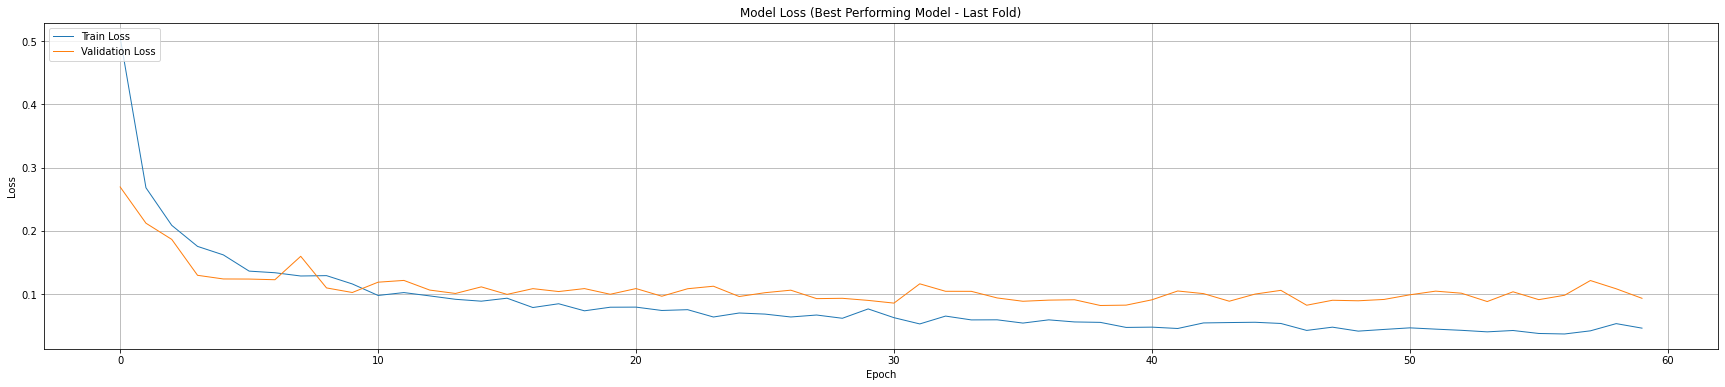

In [34]:
# Path to the history file for the last fold (best-performing model)
history_path = "kfold_models/history_fold_5.json"  # Update this with the correct file name if needed

# Load the history file
with open(history_path, "r") as f:
    best_model_history = json.load(f)

# Plot loss
plt.plot(best_model_history['loss'], label='Train Loss')
plt.plot(best_model_history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Best Performing Model - Last Fold)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

**Plotting accuracy**

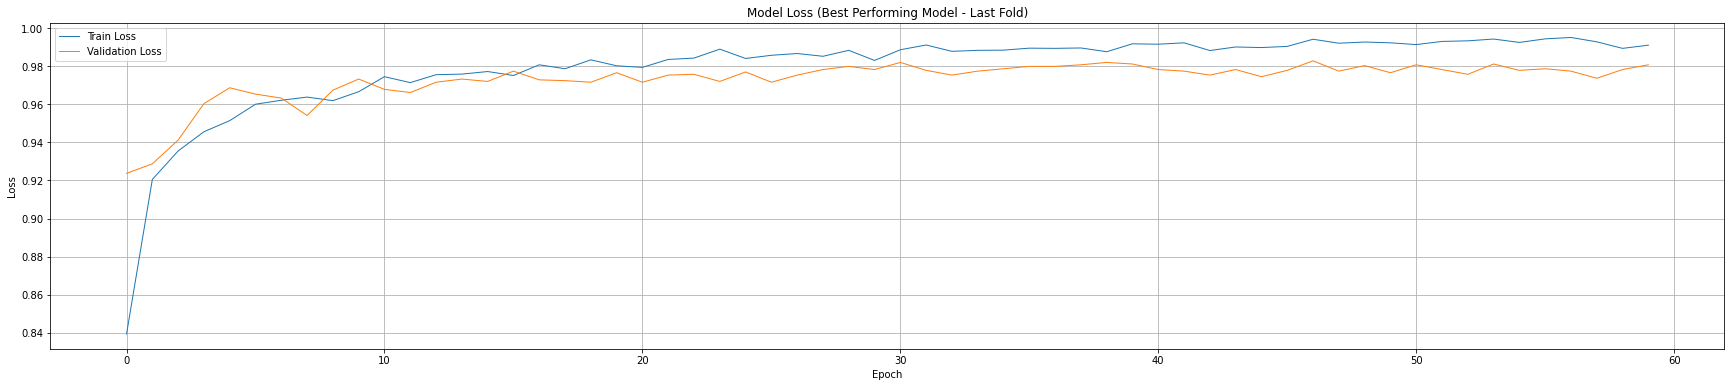

In [35]:
# Plot loss
plt.plot(best_model_history['accuracy'], label='Train Loss')
plt.plot(best_model_history['val_accuracy'], label='Validation Loss')
plt.title('Model Loss (Best Performing Model - Last Fold)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

## Finding the performance on test Data of the best performing model

In [40]:
from tensorflow.keras.models import load_model

# Path to the saved model file for the best-performing model (e.g., the last fold)
model_path = "kfold_models/model_fold_5.h5"  # Update this path if needed

# Load the model
best_model = load_model(model_path)

best_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 360, 64)           640       
_________________________________________________________________
average_pooling1d_15 (Averag (None, 179, 64)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 179, 64)           12352     
_________________________________________________________________
average_pooling1d_16 (Averag (None, 89, 64)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 89, 96)            43104     
_________________________________________________________________
average_pooling1d_17 (Averag (None, 44, 96)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4224)             

In [38]:
score = best_model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

94/94 [==============================] - 0s 2ms/step - loss: 0.1033 - accuracy: 0.9830
Test Loss: 0.10325240343809128
Test accuracy: 0.9829999804496765


In [41]:
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the intermediate layer name
layer_name = 'dense_10'  # Replace with the actual layer name in your model
intermediate_model = Model(inputs=best_model.input, outputs=best_model.get_layer(layer_name).output)

# Extract intermediate features
intermediate_features = intermediate_model.predict(test_x)  # test_x should be your test dataset

In [42]:
# Apply PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(intermediate_features)

In [43]:
# Print explained variance
print(f"Explained variance by components: {pca.explained_variance_ratio_}")

Explained variance by components: [0.4570926  0.29304564]


In [44]:
true_classes = np.argmax(test_y, axis=1)
true_classes

array([3, 2, 4, ..., 3, 4, 4])

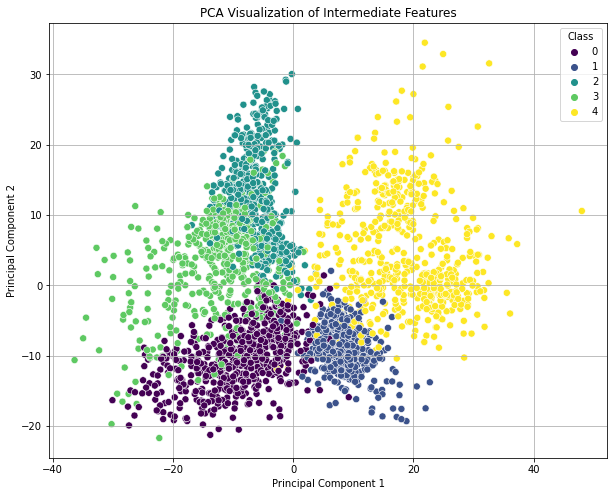

In [45]:
# Visualize PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=true_classes, palette="viridis", s=50)
plt.title("PCA Visualization of Intermediate Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Class", loc='best')
plt.show()

In [46]:
# Extract features from intermediate layer
layer_name = 'flatten_5'
intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
intermediate_features = intermediate_model.predict(test_x)

In [47]:
# Apply PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(intermediate_features)

In [48]:
# Print explained variance
print(f"Explained variance by components: {pca.explained_variance_ratio_}")

Explained variance by components: [0.11559035 0.08327495]


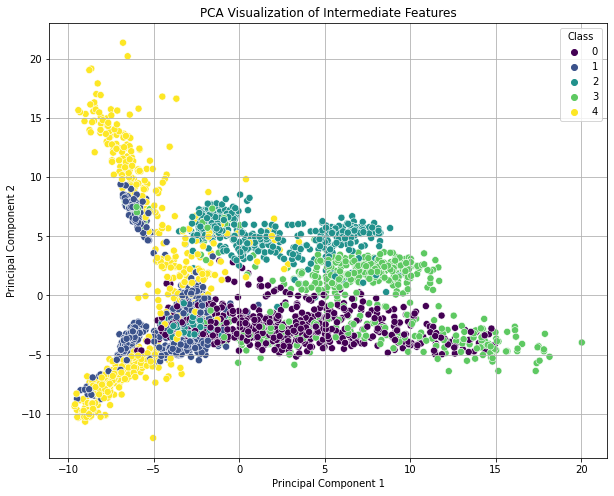

In [49]:
# Visualize PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=true_classes, palette="viridis", s=50)
plt.title("PCA Visualization of Intermediate Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Class", loc='best')
plt.show()

In [50]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Define a model that outputs activations from a specific convolutional layer
layer_name = 'conv1d_15'  # Replace with your convolutional layer's name
intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Pass a single ECG signal through the intermediate model
test_sample = test_x[0:1]  # Select a single test sample
activation_maps = intermediate_model.predict(test_sample)

print("Activation Maps Shape:", activation_maps.shape)
# Shape: (batch_size, sequence_length, num_filters)


Activation Maps Shape: (1, 360, 64)


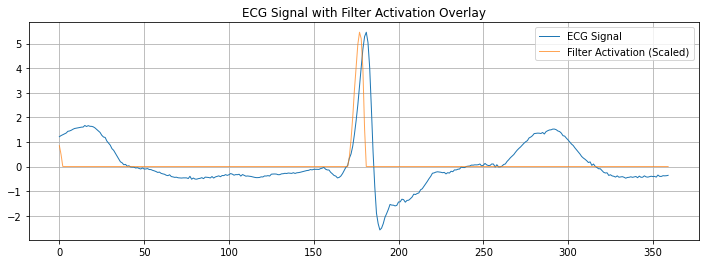

In [51]:
# Normalize the first filter's activation map
filter_activation = activation_maps[0, :, 0]
normalized_activation = filter_activation / max(filter_activation)

# Plot the original ECG signal and the activation map
plt.figure(figsize=(12, 4))
plt.plot(test_sample[0, :, 0], label="ECG Signal")  # Plot the original signal
plt.plot(normalized_activation * max(test_sample[0, :, 0]), label="Filter Activation (Scaled)", alpha=0.7)
plt.legend()
plt.title("ECG Signal with Filter Activation Overlay")
plt.show()


his plot overlays the ECG signal and the filter activation, which gives insights into which regions of the signal are strongly activating the selected filter.

Interpretation
Filter Activation Peaks:

The orange line shows the scaled activation of the filter, which peaks significantly near the sharp QRS complex in the ECG signal (around index 150–200).
This suggests that the filter is likely specialized in detecting high-frequency or high-amplitude components, such as the QRS complex.
Focus of the Filter:

Since the QRS complex corresponds to the ventricular depolarization, the filter might be focusing on sharp transitions or high-energy regions in the signal.
Other Regions:

The activation is minimal in flat or low-amplitude regions (e.g., P-wave and T-wave areas), meaning this filter doesn't respond strongly to those segments.